In [3]:
import os
import random
import shutil
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [ ]:
import os
import random
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter

# === CONFIG ===
INPUT_DIR = "glyph_images"
SYNTH_IMG_DIR = "synthetic_sentences"
SYNTH_LBL_DIR = "synthetic_sentences_labels"
YOLO_DATA_DIR = "yolo_dataset"
CANVAS_SIZE = (1500, 300)
GLYPHS_PER_SENTENCE = 10
NUM_SENTENCES = 200

# === PREPARE FOLDERS ===
os.makedirs(SYNTH_IMG_DIR, exist_ok=True)
os.makedirs(SYNTH_LBL_DIR, exist_ok=True)
os.makedirs(os.path.join(YOLO_DATA_DIR, "images", "train"), exist_ok=True)
os.makedirs(os.path.join(YOLO_DATA_DIR, "labels", "train"), exist_ok=True)

# === LOAD GLYPHS ===
glyph_files = sorted([f for f in os.listdir(INPUT_DIR) if f.endswith(".png")])[:10]
glyph_classes = {f: idx for idx, f in enumerate(glyph_files)}

# === UTILITY: Add background noise ===
def add_background_noise(image, intensity=15):
    noise = np.random.randint(0, intensity, (image.height, image.width), dtype='uint8')
    noisy_image = np.array(image).astype(np.int16) + noise
    noisy_image = np.clip(noisy_image, 0, 255).astype('uint8')
    return Image.fromarray(noisy_image)

# === GENERATE SYNTHETIC SENTENCES ===
for i in range(NUM_SENTENCES):
    canvas = Image.new('L', CANVAS_SIZE, color=255)
    x_offset = 5
    bboxes = []
    random.shuffle(glyph_files)

    for glyph_name in glyph_files:
        class_id = glyph_classes[glyph_name]
        glyph_path = os.path.join(INPUT_DIR, glyph_name)
        glyph = Image.open(glyph_path).convert('L')

        # Contrast reduction and blur
        glyph = ImageEnhance.Contrast(glyph).enhance(random.uniform(0.5, 0.9))
        glyph = glyph.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.5, 1.5)))

        # Rotation
        angle = random.uniform(-10, 10)
        glyph = glyph.rotate(angle, expand=True, fillcolor=255)

        # Crop non-white regions
        glyph_np = np.array(glyph)
        mask = glyph_np < 250
        if not np.any(mask):
            continue

        coords = np.argwhere(mask)
        y0, x0 = coords.min(axis=0)
        y1, x1 = coords.max(axis=0) + 1
        cropped = glyph.crop((x0, y0, x1, y1))

        # Resize with scale factor
        max_height = CANVAS_SIZE[1] - 10
        scale = random.uniform(0.8, 1.2)
        if cropped.height > max_height:
            scale *= max_height / cropped.height
        new_size = (int(cropped.width * scale), int(cropped.height * scale))
        cropped = cropped.resize(new_size, resample=Image.BILINEAR)

        # Vertical jitter
        y_jitter = random.randint(-3, 3)
        y_offset = (CANVAS_SIZE[1] - cropped.height) // 2 + y_jitter

        # Paste glyph
        canvas.paste(cropped, (x_offset, y_offset))

        # Bounding box
        bbox_x_center = (x_offset + cropped.width / 2) / CANVAS_SIZE[0]
        bbox_y_center = (y_offset + cropped.height / 2) / CANVAS_SIZE[1]
        bbox_width = cropped.width / CANVAS_SIZE[0]
        bbox_height = cropped.height / CANVAS_SIZE[1]
        bboxes.append((class_id, bbox_x_center, bbox_y_center, bbox_width, bbox_height))

        # Tighter spacing
        x_offset += cropped.width + random.randint(-15,-10)

    # Add noise to the final image
    canvas = add_background_noise(canvas, intensity=15)

    # Save image and label
    img_path = os.path.join(SYNTH_IMG_DIR, f"sentence_{i}.png")
    canvas.convert("RGB").save(img_path)

    label_path = os.path.join(SYNTH_LBL_DIR, f"sentence_{i}.txt")
    with open(label_path, 'w') as f:
        for bbox in bboxes:
            f.write(f"{bbox[0]} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f} {bbox[4]:.6f}\n")

print("✅ Synthetic sentences generated with noise, blur, scaling, and jitter.")


✅ Synthetic sentences generated with noise, blur, scaling, and jitter.


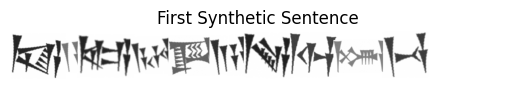

In [6]:
first_image_path = os.path.join(SYNTH_IMG_DIR, "sentence_1.png")

# Load and display the image
img = Image.open(first_image_path)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title("First Synthetic Sentence")
plt.show()

In [7]:
import os
import shutil

YOLO_DATA_DIR = "yolo_dataset"
SENT_IMG_DIR = "synthetic_sentences"
SENT_LBL_DIR = "synthetic_sentences_labels"

for split in ["train", "val"]:  # assuming val might be added later
    os.makedirs(os.path.join(YOLO_DATA_DIR, "images", split), exist_ok=True)
    os.makedirs(os.path.join(YOLO_DATA_DIR, "labels", split), exist_ok=True)

for fn in os.listdir(SENT_IMG_DIR):
    if fn.endswith(".png"):
        shutil.copy(os.path.join(SENT_IMG_DIR, fn), os.path.join(YOLO_DATA_DIR, "images", "train", fn))

for fn in os.listdir(SENT_LBL_DIR):
    if fn.endswith(".txt"):
        shutil.copy(os.path.join(SENT_LBL_DIR, fn), os.path.join(YOLO_DATA_DIR, "labels", "train", fn))

print("✅ YOLO dataset folders populated.")


✅ YOLO dataset folders populated.


In [ ]:
# Copy into YOLO folder
for fn in os.listdir(SENT_IMG_DIR):
    if fn.endswith(".png"):
        src = os.path.join(SENT_IMG_DIR, fn)
        dst = os.path.join(YOLO_DATA_DIR, "images", "train", fn)
        shutil.copy(src, dst)
for fn in os.listdir(SENT_LBL_DIR):
    if fn.endswith(".txt"):
        src = os.path.join(SENT_LBL_DIR, fn)
        dst = os.path.join(YOLO_DATA_DIR, "labels", "train", fn)
        shutil.copy(src, dst)

# ─── WRITE DATASET.YAML ───────────────────────────────────────────────────────
yaml_txt = f"""
path: {os.path.abspath(YOLO_DATA_DIR)}
train: images/train
val: images/train

names:
"""
for cid in range(GLYPHS_PER_SENTENCE):
    yaml_txt += f"  {cid}: Glyph_{cid}\n"

with open(os.path.join(YOLO_DATA_DIR, "glyphs-seg.yaml"), "w") as f:
    f.write(yaml_txt)

# ─── TRAIN SEGMENTATION MODEL ─────────────────────────────────────────────────
model = YOLO("yolov8n.pt", task='segment')

model.train(
    data=os.path.join(YOLO_DATA_DIR, "glyphs-seg.yaml"),
    epochs=50,
    imgsz=640,
    batch=8,
    patience=10,
)

# ─── TRAIN DETECTION MODEL ────────────────────────────────────────────────────
# Save the trained model
model_save_path = "models/glyph_detector.pt"
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Wait for training to complete and then copy the model
if os.path.exists("runs/detect/train/weights/best.pt"):
    shutil.copy("runs/detect/train/weights/best.pt", model_save_path)
    print(f"✅ Done: synthetic data with jitter & segmentation training complete!")
    print(f"✅ Model saved to: {model_save_path}")
else:
    print("⚠️ Training might not have produced weight files yet.")
    print("Please check 'runs/segment/train/weights/' directory after training completes.")

Ultralytics 8.3.134 🚀 Python-3.10.16 torch-2.7.0+cu126 CUDA:0 (Tesla V100-PCIE-16GB, 16151MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset/glyphs-seg.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, 

train: Scanning /home/default/AI-project/yolo_dataset/labels/train.cache... 200 images, 0 backgrounds, 3 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

train: /home/default/AI-project/yolo_dataset/images/train/sentence_62.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.006667]
train: /home/default/AI-project/yolo_dataset/images/train/sentence_69.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.053333]
train: /home/default/AI-project/yolo_dataset/images/train/sentence_9.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.013333]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1573.4±1042.0 MB/s, size: 121.9 KB)


val: Scanning /home/default/AI-project/yolo_dataset/labels/train.cache... 200 images, 0 backgrounds, 3 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

train: /home/default/AI-project/yolo_dataset/images/train/sentence_62.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.006667]
train: /home/default/AI-project/yolo_dataset/images/train/sentence_69.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.053333]
train: /home/default/AI-project/yolo_dataset/images/train/sentence_9.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.013333]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
MLflow: logging run_id(1e67fe6256f344ca93300625a6f47d9f) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
WARNING ⚠️ MLflow: Failed to initialize: Changing param values is not allowed. Param with key='epochs' was already logged with value='50' for run ID='1e67fe6256f344ca93300625a6f47d9f'. Attempted logging new value '5'.
WARNING ⚠️ MLflow: Not tracking this run
Image sizes 640 train, 640 val
Using 6 dataloader workers
Logging results to runs/detect/train4
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instan

        1/5      1.23G      1.797      4.283      1.332         92        640: 100%|██████████| 25/25 [00:02<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00, 12.23it/s]

                   all        197       1970      0.027      0.793     0.0754     0.0425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.25G        1.1      3.289     0.9608        103        640: 100%|██████████| 25/25 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00, 12.18it/s]

                   all        197       1970     0.0341      0.997      0.206      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.27G     0.9905       2.59     0.9512        107        640: 100%|██████████| 25/25 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00, 11.85it/s]

                   all        197       1970      0.577      0.189      0.413      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.28G     0.9345      2.175     0.9356         71        640: 100%|██████████| 25/25 [00:01<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00, 11.90it/s]

                   all        197       1970      0.705      0.656      0.753      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5       1.3G     0.8617      1.912     0.9153        111        640: 100%|██████████| 25/25 [00:01<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00, 11.58it/s]

                   all        197       1970       0.73      0.802      0.857       0.71



5 epochs completed in 0.005 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 6.2MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.134 🚀 Python-3.10.16 torch-2.7.0+cu126 CUDA:0 (Tesla V100-PCIE-16GB, 16151MiB)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.09it/s]


                   all        197       1970      0.731      0.801      0.857       0.71
               Glyph_0        197        197      0.994      0.807      0.983      0.737
               Glyph_1        197        197      0.861      0.314      0.807      0.682
               Glyph_2        197        197      0.792      0.715      0.843      0.699
               Glyph_3        197        197      0.916      0.888      0.964      0.761
               Glyph_4        197        197       0.42      0.975      0.753      0.659
               Glyph_5        197        197      0.337      0.985      0.899      0.769
               Glyph_6        197        197      0.581      0.563      0.583      0.503
               Glyph_7        197        197      0.862      0.924      0.968      0.821
               Glyph_8        197        197      0.594      0.853      0.778      0.662
               Glyph_9        197        197      0.951       0.99      0.993      0.809
Speed: 0.0ms preproce


0: 64x640 1 Glyph_1, 1 Glyph_3, 1 Glyph_5, 1 Glyph_7, 1 Glyph_8, 1 Glyph_9, 41.6ms
Speed: 0.9ms preprocess, 41.6ms inference, 2.5ms postprocess per image at shape (1, 3, 64, 640)


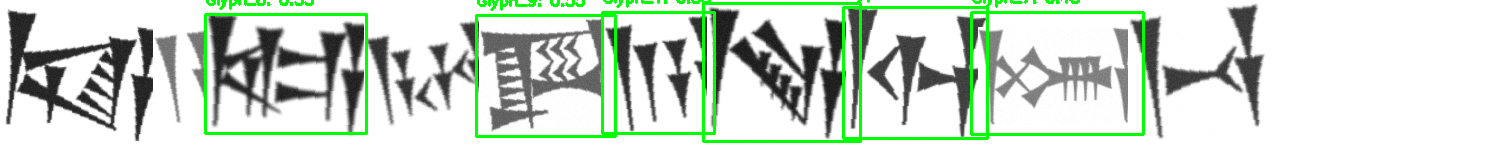

✅ Done: Testing complete, results displayed!


In [10]:
import cv2
import numpy as np
from PIL import Image
from IPython.display import display

# ─── PARAMETERS ────────────────────────────────────────────────────────────────
TEST_IMG_PATH = "yolo_dataset/images/train/sentence_1.png"  # Path to a single test image

# ─── TEST PREDICTIONS ON SINGLE IMAGE ─────────────────────────────────────────
def test_model_on_image(img_path):
    # Load the test image
    img = Image.open(img_path)
    
    # Perform segmentation prediction
    results = model(img)  # Use the pre-trained model
    
    # The results are now a list of detections
    result = results[0]  # The first (and only) result
    
    # Get predictions (boxes, scores, etc.)
    boxes = result.boxes.xyxy.cpu().numpy()  # Bounding boxes (xyxy format)
    confidences = result.boxes.conf.cpu().numpy()  # Confidence scores
    class_ids = result.boxes.cls.cpu().numpy()  # Class IDs
    
    # Convert image for visualization (RGB -> BGR for OpenCV)
    img_cv2 = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    
    # Draw predictions on the image
    for box, conf, class_id in zip(boxes, confidences, class_ids):
        x1, y1, x2, y2 = map(int, box)
        color = (0, 255, 0)  # Green color for bounding box
        cv2.rectangle(img_cv2, (x1, y1), (x2, y2), color, 2)
        
        # Draw label and confidence
        label = f"Glyph_{int(class_id)}: {conf:.2f}"
        cv2.putText(img_cv2, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Convert back to RGB for displaying with PIL
    img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    
    # Display in Jupyter Notebook
    display(img_pil)

# Test the model on the single image
test_model_on_image(TEST_IMG_PATH)

print("✅ Done: Testing complete, results displayed!")
